In [1]:
# Import Julia packages
using DrWatson
@quickactivate
using Revise
using LinearAlgebra
using DelimitedFiles
using SparseArrays
using StaticArrays
using BlockArrays
using CairoMakie
using UnPack
using FromFile
using GeometryBasics
using Random
using Colors
using JLD2
using LaTeXStrings
using Glob
using Printf
using ColorSchemes
using Statistics
using Graphs


@from "$(projectdir())/src/VertexModelContainers.jl" using VertexModelContainers
@from "$(projectdir())/src/Laplacians.jl" using Laplacians
@from "$(projectdir())/src/AnalysisFunctions.jl" using AnalysisFunctions
@from "$(projectdir())/src/CellProperties.jl" using CellProperties

In [2]:
function matrix_breakdown(A, B)
    nVerts=size(A)[2]
    nEdges=size(A)[1]
    nCells=size(B)[1]
    edgesP=vec((abs.(ones(nCells)'*B)))
    vertsP=vec((0.5.*edgesP'*abs.(A))')
    edgesB=vec(abs.(A*(ones(nVerts).-vertsP)))
    edgesI=vec(ones(nEdges).-edgesB.-edgesP)
    vertsI=vec(ones(nVerts)-vertsP)
    cellsB=vec(abs.(abs.(B)*edgesP))
    cellsB[findall(x->x!=0,cellsB)].=1
    cellsI=ones(nCells)-cellsB
    
    edgesI=((abs.(B))'*Diagonal(cellsI)*abs.(B))*edgesI
    edgesI[findall(x->x!=0, edgesI)].=1


    vertsI=((abs.(A))'*Diagonal(edgesI)*abs.(A))*vertsI
    vertsI[findall(x->x!=0, vertsI)].=1


    return edgesP, edgesB, edgesI, vertsP, vertsI, cellsB, cellsI
end

matrix_breakdown (generic function with 1 method)

In [ ]:
f=Glob.glob("pseudo2D/500_cells/new_layer_3/Final_configs","C:\\Documents\\VM_code\\VertexModel\\data\\sims" )[end]
ff=Glob.glob("systemDataFinal*L₀=2.0_*ΓA=-0.5_*Γa=0.1.jld2",f)[end]
@unpack R, matrices, params = load(ff)
@unpack nCells,nEdges,nVerts, Γa, ΓA, ΓL, L₀ = params
@unpack cellAreas,cellPerimeters, cellTensions, cellPositions,cellPressures,cellVertexOrders, cellEdgeCount, edgeLengths,edgeTangents,vertexAreas,A,Ā,B,B̄,C, ϵ, cellHeights = matrices
sort(norm.(edgeTangents))
mkpath(datadir(f,"plots"))

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\pdSa4\src\data\reconstructing_datatypes.jl:574
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\pdSa4\src\data\reconstructing_datatypes.jl:574


"C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims\\pseudo2D\\500_cells\\new_layer_3\\Final_configs\\plots"

In [ ]:
edgesP, edgesB, edgesI, vertsP, vertsI, cellsB, cellsI=matrix_breakdown(A,B)
# edgesP=vec((abs.(ones(nCells)'*B)))
# cellsB=vec(abs.(abs.(B)*edgesP))
# cellsB[findall(x->x!=0,cellsB)].=1
# cellsI=ones(nCells)-cellsB

h=mean(cellHeights)
Ph=(cellAreas.*h .-1.0)
Th=Γa.*(2.0.*cellAreas .+ h.*cellPerimeters .- 1.0)
Thc=2*ΓL.*(cellPerimeters.-L₀)

Fz=cellAreas.*Ph .+ cellPerimeters.*(ΓA/2 .+ Th)



cellVolumes=cellAreas.*h
cellSurface=2.0.*cellAreas+cellPerimeters.*cellHeights
shapeParam2D=cellPerimeters./(sqrt.(cellAreas))
shapeParam3D=cellSurface./(cellVolumes.^(2/3))


Peff2D=(cellPressures .+ cellTensions.*cellPerimeters./(2.0.*cellAreas))
Peff3D= (1.0./(3.0*cellVolumes)).* (2.0 .* cellPressures.*cellAreas .+ cellTensions.*cellPerimeters .+ h.*Fz)
Peff3DV= (1.0./(3.0*cellVolumes)).* (3.0.*Ph.*h.*cellAreas.+  2.0 .*Th.*(2.0.*cellAreas .+ h.*cellPerimeters) .+ Thc .*cellPerimeters .+2.0.* h.*(cellPerimeters.*(ΓA/2)))


cellQ, cellJ=makeCellQandJ(params, matrices)
ss2D=cellTensions.*cellPerimeters.*(sqrt.(-det.(cellJ)))./cellAreas
ssZ=Peff3D.- Peff2D./h



scrit=[2*sqrt(n*tan( pi /n )) for n in 4:10]

spdiff=shapeParam2D
spdiff[cellEdgeCount.==4].-=scrit[1]
spdiff[cellEdgeCount.==5].-=scrit[2]
spdiff[cellEdgeCount.==6].-=scrit[3]
spdiff[cellEdgeCount.==7].-=scrit[4]
spdiff[cellEdgeCount.==8].-=scrit[5]

spdiff_norm=spdiff
spdiff_norm[cellEdgeCount.==4]./=scrit[1]
spdiff_norm[cellEdgeCount.==5]./=scrit[2]
spdiff_norm[cellEdgeCount.==6]./=scrit[3]
spdiff_norm[cellEdgeCount.==7]./=scrit[4]
spdiff_norm[cellEdgeCount.==8]./=scrit[5]

shapeParam2D=cellPerimeters./(sqrt.(cellAreas))

edgeTensions=abs.(B)'*cellTensions

500-element Vector{Float64}:
  0.054025321983047915
  0.02975556522391986
 -0.017341498729388033
  0.03773848996513461
 -0.0297544649345366
  0.0010674249752326804
 -0.008612885572892973
 -0.009234404855506605
 -0.009537320090225112
 -0.04934457085324113
  ⋮
 -0.05505030768711611
 -0.033540811203468725
 -0.055726652356916886
 -0.022115560090022995
 -0.042078520619949
 -0.055694622420444005
 -0.05608237438597872
  0.03182625632361115
 -0.01126853343916655

In [9]:
cellPolygons = makeCellPolygons(R,params,matrices)


500-element Vector{Vector{Point2{Float64}}}:
 [[3.3260884243223194, -7.098795899008965], [3.076586786301776, -7.193117461310821], [3.0322305801069236, -7.135852567344938], [2.81499781473325, -6.9362450476978275], [2.729290575738469, -6.742081231803952], [2.951191376378483, -6.607813224251639], [3.4741858177656053, -6.5493168426026065], [3.6915387469933467, -6.837325491024234]]
 [[2.2599179248039594, -1.6014808568667118], [1.7498374367202978, -1.3077159804412224], [1.8095255931038603, -1.0590492559671847], [1.9275362149464332, -0.7743520137289538], [2.245699715074351, -0.8062251157996961], [2.4672974605628033, -0.9060519435819074], [2.278897231453666, -1.5695340594128957]]
 [[-6.582365605919031, 2.657339133111117], [-6.980893398161414, 2.7584136079992745], [-6.785902400514578, 3.2676840927524458], [-6.206177649627568, 3.253741491394965], [-6.203573694199282, 2.7344572070285635]]
 [[-3.037387511621658, 6.835009624295171], [-2.6687771998153953, 6.712030411075529], [-2.5618636759798346, 6.

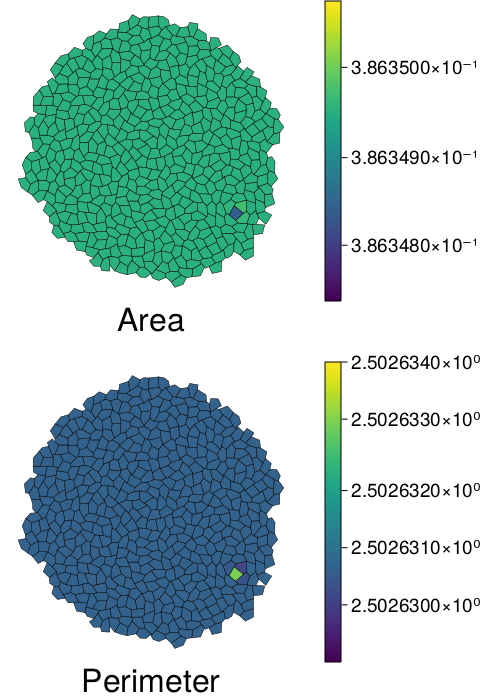

In [ ]:
cellPolygons = makeCellPolygons(R,params,matrices)
Aevlims=(minimum(abs.(cellAreas[1:nCells]))-1e-6, maximum(abs.(cellAreas[1:nCells]))+1e-6)
Levlims=(minimum(abs.(cellPerimeters[1:nCells]))-1e-6, maximum(abs.(cellPerimeters[1:nCells]))+1e-6)
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=cellAreas[i],colormap=:viridis,colorrange=Aevlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a2,cellPolygons[i],color=cellPerimeters[i],colormap=:viridis,colorrange=Levlims, strokecolor=(:black,1.0),strokewidth=0.5)
end


colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Aevlims,colormap=:viridis,flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=Levlims,colormap=:viridis,flipaxis=true)


Label(fig[1,1,Bottom()],string("Area"),fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],string("Perimeter"),fontsize = 32, rotation=0)
resize_to_layout!(fig)
save(datadir(f,"plots","AL_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
fig

In [5]:
G=dropzeros!(sparse([Diagonal(4 .*Γa .+cellHeights.^2) Diagonal(2 .*Γa .*cellHeights)
Diagonal(2 .*Γa .*cellHeights) Diagonal(2 .*ΓL .+ Γa .*cellHeights.^2)]))
M=makeM(matrices)
Lv=M'*G*M

1080×1080 SparseMatrixCSC{SMatrix{2, 2, Float64, 4}, Int64} with 13506 stored entries:
⎡⣻⣾⡜⣲⡿⣽⣖⣻⡼⢥⣻⡛⡳⣷⣷⣷⠶⢯⢽⣽⣛⣒⢜⣟⣸⣷⣶⣳⢴⣏⣺⡶⢧⡷⣽⠿⣿⠍⠦⠌⎤
⎢⢲⣩⡑⢌⠟⢼⣾⣯⡿⡳⢳⣷⣯⡿⣌⣟⣯⢚⡷⢻⡻⠶⢷⣾⡿⣿⣯⡿⣟⣽⠛⣏⡮⢽⣉⣯⡫⢾⠮⡖⎥
⎢⣟⣯⣛⣅⠿⣧⢎⣩⠛⠿⣼⣮⣍⢿⢩⣙⠀⠿⠻⢦⣾⣬⣭⡿⡵⢭⢯⢇⢻⣸⡿⠃⢻⠾⠋⣻⣿⠖⡫⣧⎥
⎢⣼⣹⡾⣿⡎⣱⢱⣶⠮⡑⣹⢿⠿⣗⢷⡭⣥⣅⡬⣟⣓⠺⢛⡿⣮⡶⡿⣼⣷⣙⣯⢯⢽⣯⣲⢯⡊⡌⢑⠣⎥
⎢⠖⣏⢿⡫⣿⡄⢎⠣⠛⢄⡲⡘⠱⢐⡎⡾⠿⢿⣿⣆⣒⢃⣔⡜⣸⡭⡿⡇⡋⠟⡿⡿⢞⣾⠿⡞⢯⣵⣯⡿⎥
⎢⣿⠺⢽⣶⡲⣿⣷⣞⣘⠪⢿⣷⣲⢼⣏⡍⠃⢔⣚⣽⣿⣿⣿⡾⣏⣟⣿⡕⣌⢔⠏⢈⣠⠁⡐⠲⡴⣁⣊⣹⎥
⎢⢽⣮⣯⡿⣧⣝⢿⢧⢑⢂⣘⣞⣵⣿⠱⠬⡓⠅⠛⣎⣡⣯⡿⡿⡿⢒⣞⣻⠾⣫⡎⠿⢜⢒⡂⠪⠙⢞⣷⠗⎥
⎢⢽⣿⣦⢽⣇⢲⡝⡷⣪⡭⡏⠽⡑⡆⣻⣾⢥⣵⡩⡼⠡⠪⡭⠣⢵⢗⢨⠷⠷⢷⣪⣻⣼⡯⢉⣍⣵⠨⣸⡄⎥
⎢⡼⣇⣫⢛⣤⡄⠅⢿⣿⣇⢉⢄⠝⠌⢅⣷⢿⢗⣵⡄⡀⡈⠐⠹⢑⡲⡟⢭⢘⢟⡿⣿⡵⢿⢟⣿⡧⣴⢜⣃⎥
⎢⣗⣷⣽⣋⠻⣆⣦⢯⠻⢿⣞⣼⡻⢤⣃⡮⠑⠿⠻⣦⣑⠅⣄⡜⣱⣚⣤⣂⡹⢋⢿⠊⠯⡿⠟⠭⠿⠿⠟⠇⎥
⎢⢻⢸⢻⡎⡚⣿⣹⡘⠼⢘⣿⣿⡥⣾⡡⡂⡀⠨⠕⠜⡿⣯⣥⢟⣖⢮⣗⢩⠽⣽⣄⠈⠘⡲⠀⠸⡖⡆⠌⠥⎥
⎢⣶⢵⣹⣷⣧⡿⣿⡴⣐⠽⣻⡿⣿⡯⠧⡋⣔⡀⣀⠽⣥⢟⢵⣷⣻⠯⠭⡴⢶⣂⢃⢄⣰⠂⠨⠅⡀⠠⡸⣗⎥
⎢⢶⣾⣿⣯⡕⣏⢪⡿⡖⡾⣯⢽⢻⢋⢵⢗⢱⡰⣱⢺⡸⣝⡿⡞⣕⣽⣗⡵⠔⡖⣙⢡⢳⠯⣴⠸⣁⣨⢪⣳⎥
⎢⢼⣻⣯⡿⠯⢗⣛⣯⠿⠯⢟⠿⣾⣹⢦⡖⡟⣍⠠⢻⡝⣙⢃⡧⢝⡽⣿⣿⣣⡬⡳⢙⡰⣉⠑⠐⢱⠁⣓⡆⎥
⎢⡴⢷⣟⣽⣛⣲⣝⢻⣯⠌⢂⢝⡾⣣⢽⣇⣶⢔⡷⢊⣗⣧⠸⢳⢰⠥⡉⡾⣿⣿⡘⢹⣈⠨⢓⣥⡌⣩⠘⡁⎥
⎢⢺⡾⡿⢤⠿⠋⡯⣟⣿⡯⡋⢁⣮⡍⣮⣺⣿⣯⡻⠓⡀⠙⠉⢔⠗⣘⣝⢊⣖⣈⣿⣿⡷⡾⣳⣵⣟⠟⣠⣡⎥
⎢⢭⡷⣎⣏⣻⡖⡷⣷⣺⣵⠄⠚⢲⢑⡶⡿⣵⣏⣯⡧⢲⡠⠰⠚⡽⡖⡔⢪⡂⡘⣹⡯⣛⢜⣯⣫⢖⡌⢭⢬⎥
⎢⣷⡟⡧⣼⣯⣠⡼⣞⣻⠧⢰⡈⡨⡈⡇⢴⣿⣵⡟⡅⣀⡀⠆⠆⣐⡛⢑⠀⠝⣴⢝⣾⡯⣻⣿⣿⡼⡬⡸⡖⎥
⎢⡟⠟⣫⣎⢻⠟⡊⠬⢏⣷⠔⢫⣳⢄⡑⡛⢉⣯⣿⡇⠸⠭⠀⡈⡁⣸⠕⠒⡆⣩⣿⠝⡘⠵⡒⡯⢿⣷⡇⠃⎥
⎣⡈⠇⢪⠧⠯⣮⠵⡐⣯⡿⣎⣸⢽⠟⠒⠾⠶⢱⠿⠅⠆⡅⢶⢮⢮⣲⠹⠼⠖⠠⠄⣺⡃⣗⢲⠮⠭⠉⠿⣧⎦

In [6]:


X=makeX(params, matrices)



1000×1080×1080 Array{SMatrix{2, 2, Float64}, 3}:
[:, :, 1] =
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]  …  [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]  …  [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 ⋮                                       ⋱  
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]     [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0

In [7]:
g=vcat(cellPressures, cellTensions)
gX=Matrix{SMatrix{2,2,Float64,4}}(undef,nVerts,nVerts)
fill!(gX,@SMatrix zeros(2,2))
for α=1:2*nCells
    gX+=g[α]X[α, :,:]
end

In [8]:
H=Matrix(mortar(Lv)).+Matrix(mortar(gX))
evalH, evecH=eigen(H)
evecH=Matrix(qr(evecH).Q)

Lvevals,Lvevecs=LAPACK.syev!('V','U',deepcopy(Matrix(mortar(Lv))))


([-8.14272978408362e-15, -5.718115345664462e-15, -5.355206636517957e-15, -5.204472282561473e-15, -5.1660826823165784e-15, -5.0721631137593744e-15, -5.035896460783442e-15, -5.028418689601204e-15, -4.989995925643855e-15, -4.9245740406915434e-15  …  7.743837030777514, 7.755161306552323, 7.773082868615211, 7.792547716345016, 7.908468377752972, 7.935702175532428, 8.365233314337587, 8.390211131580815, 8.495111597703797, 8.565484607276753], [-0.019116959590074218 -0.004022585735536264 … 0.007685036947958495 -3.9047950557954794e-8; -0.026365178397521553 -0.0036800055715394786 … 0.02061327073249413 4.82907774613534e-9; … ; 0.09957306467959673 -0.008020818652228747 … -1.8207627685159786e-7 1.1535313301346689e-8; -0.15387019811695782 0.003935753399110789 … 9.806259001460157e-8 1.098288657035932e-8])

In [9]:
dUdHH=sum(cellAreas.^2 .+ Γa.*cellPerimeters.^2)
dPdH= 2.0 .*cellAreas.*cellHeights .+ 2.0 .* Γa .*cellPerimeters.-1
dTdH= (ΓA/2.0) .+ Γa.*cellHeights.*cellPerimeters .+ Γa .*(2.0 .*cellAreas .+ cellHeights.*cellPerimeters .-1)
dgdH=vcat(dPdH, dTdH)



1000-element Vector{Float64}:
 0.5654451756539913
 0.5654451761426667
 0.5654451771996012
 0.5654451771960793
 0.565445178931119
 0.5654451762938901
 0.5654451772064091
 0.565445177187534
 0.5654451767474726
 0.5654451770667994
 ⋮
 0.41708542995911513
 0.4170854299701998
 0.4170854299688352
 0.4170854300416387
 0.4170854298998697
 0.41708542996736414
 0.41708542998724585
 0.4170854299434588
 0.4170854299684182

In [ ]:
H0=H-(1/dUdHH).*Matrix(mortar((M'*dgdH)*(dgdH'*M))) #Hessian for μ->0
#evalH0, evecH0=eigen(H0)
evalH0,evecH0=LAPACK.syev!('V','U',deepcopy(H0))
writedlm(datadir(f,"evalH_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".csv"), real(evalH0), ',')


In [11]:
Lv0=Matrix(mortar(Lv))-(1/dUdHH).*Matrix(mortar((M'*dgdH)*(dgdH'*M)))
#evalLv0, evecLv0=eigen(Lv0)
evalLv0,evecLv0=LAPACK.syev!('V','U',deepcopy(Lv0))
writedlm(datadir(f,"evalLv_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".csv"), real(evalLv0), ',')


In [12]:
D=evecLv0'*Matrix(mortar(gX))*evecLv0
DD=D + Diagonal(evalLv0)
evalDD,evecDD=LAPACK.syev!('V','U',deepcopy(DD))


([-5.975815121243422e-7, -3.994618452612095e-7, -3.0618720967694625e-7, -2.2740981932317476e-7, -2.000929101392602e-7, -1.3510139242866935e-7, -5.8704926257905536e-8, -3.746498890411167e-8, -3.199466671828811e-8, -1.9054675782848102e-8  …  7.737708080851974, 7.751155380024468, 7.772436013913698, 7.792505880064059, 7.901472736999449, 7.935345229957208, 8.356495614073825, 8.386523634206021, 8.491395808853634, 8.5575465955551], [-0.02363814647988738 -0.001996537932398184 … -1.2638498686402324e-11 5.030153983335111e-12; 0.04127690753780863 0.01889830782479172 … -3.08503510167831e-11 3.0241499376310017e-12; … ; -5.4765321379719104e-11 -4.519133321783215e-13 … 0.9999999999999967 5.688813494746878e-10; -5.960309788690018e-12 8.400229731010133e-12 … -5.688812955873541e-10 0.9999999999999982])

In [ ]:
evmapLv=[evecDD[:,x]'*(Diagonal(evalLv0))*evecDD[:,x] for x in 1:2nVerts]
evmapgX=[evecDD[:,x]'*(D)*evecDD[:,x] for x in 1:2nVerts]

writedlm(datadir(f,"evmapLv_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".csv"), real(evmapLv), ',')
writedlm(datadir(f,"evmapgX_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".csv"), real(evmapgX), ',')



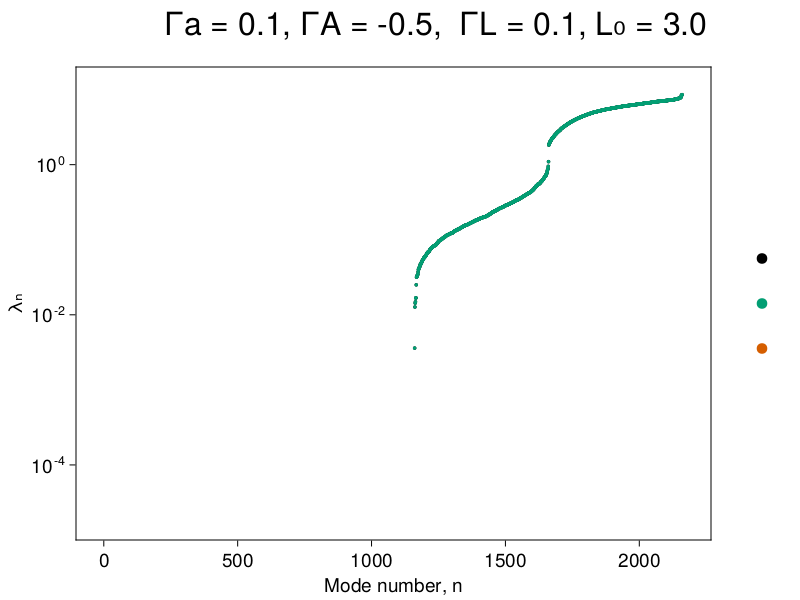

In [ ]:
perm=sortperm((abs.(evalH0)))
nv=LinRange(1, 2*nVerts, 2*nVerts)
nc=LinRange(2*nVerts-2*nCells+1, 2*nVerts, 2*nCells)
fig = Figure()
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
ax=Axis(fig[1, 1], xlabel="Mode number, n", ylabel="λₙ", yscale=log10)
hidedecorations!(ax, grid=true, ticks=false, label=false,ticklabels = false)
scatter!(ax,nv[4:2*nVerts], ((abs.(evalH0[perm])))[4:2*nVerts], color=:black,markersize=5, label=L"\lambda_n,\, \mathcal{H}")



scatter!(ax,nv[4:2*nVerts], ((abs.(evmapLv[perm])))[4:2*nVerts], color=ColorSchemes.seaborn_colorblind6[2],markersize=5, label=L"\lambda_n,\, \mathcal{L}_v^G")
scatter!(ax,nv[4:2*nVerts], ((abs.(evmapgX[perm])))[4:2*nVerts], color=ColorSchemes.seaborn_colorblind6[3],markersize=5, label=L"\lambda_n,\, \mathcal{H}")




elem_1 = [MarkerElement(color = :black, marker = :circle, markersize = 15)]

elem_2 = [MarkerElement(color = ColorSchemes.seaborn_colorblind6[2], marker = :circle, markersize = 15)]

elem_3 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 15)]

Legend(fig[1, 2],#
    [elem_1, elem_2, elem_3],
    ["","",""],
    patchsize = (35, 35), rowgap = 10, framevisible = false)
resize_to_layout!(fig)

ylims!(low=1e-5, high=2e1)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*",  ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))

save(datadir(f,"plots","Mode_contributions_1e-5_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
fig

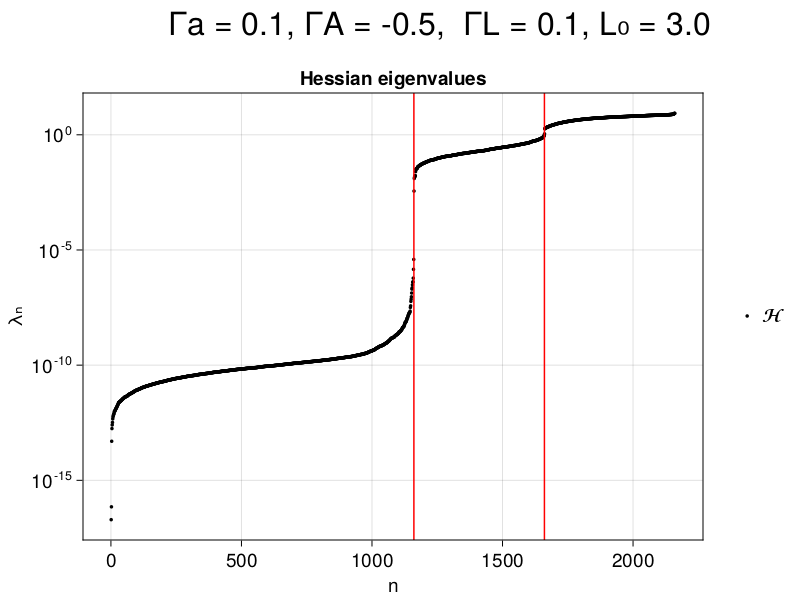

In [22]:
perm=sortperm((abs.(evalH0)))
n=LinRange(1, 2*nVerts, 2*nVerts+1)
nold=LinRange(1, 2*nVerts, 2*nVerts)
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel="λₙ", title="Hessian eigenvalues", yscale=log10)

scatter!(ax,nold, (abs.(evalH0[perm])), color=:black, label=L"\mathcal{H}", markersize=5)


vlines!(ax,2*nVerts-(2*nCells) +0.5, color=:red)
vlines!(ax,2*nVerts-(nCells) +0.5, color=:red)
fig[1, 2] = Legend(fig, ax, framevisible = false)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*",  ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
#ylims!(ax, 5e-6, nothing)
save(datadir(f,"plots","Hessian_Evals_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)
fig

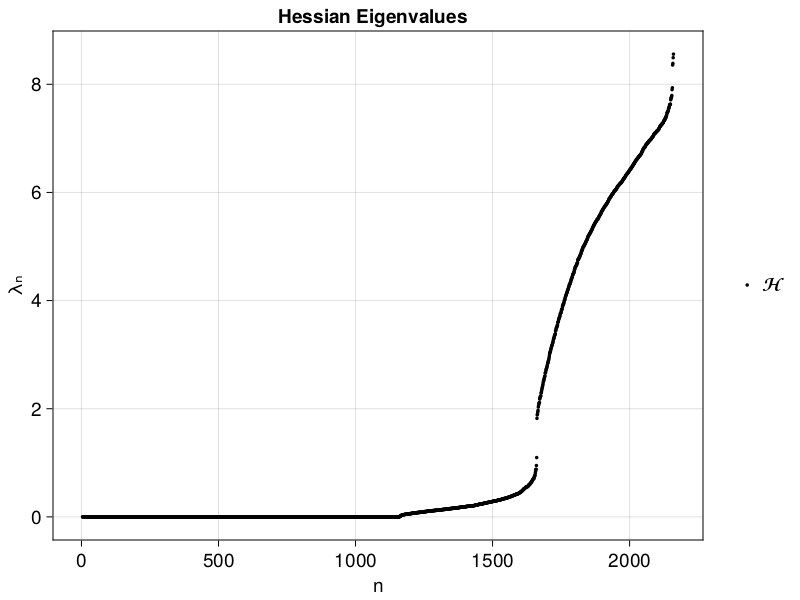

In [23]:
n=LinRange(1, 2*nVerts, 2*nVerts+1)
nold=LinRange(1, 2*nVerts, 2*nVerts)
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel="λₙ", title="Hessian Eigenvalues  ")

scatter!(ax,nold[4:end], (abs.(evalH0))[4:end], color=:black, label=L"\mathcal{H}", markersize=5)



fig[1, 2] = Legend(fig, ax, framevisible = false)
#save(datadir(f,"plots","MTGMgX_Evals_Heightdep_non-zero.png"),fig)
fig

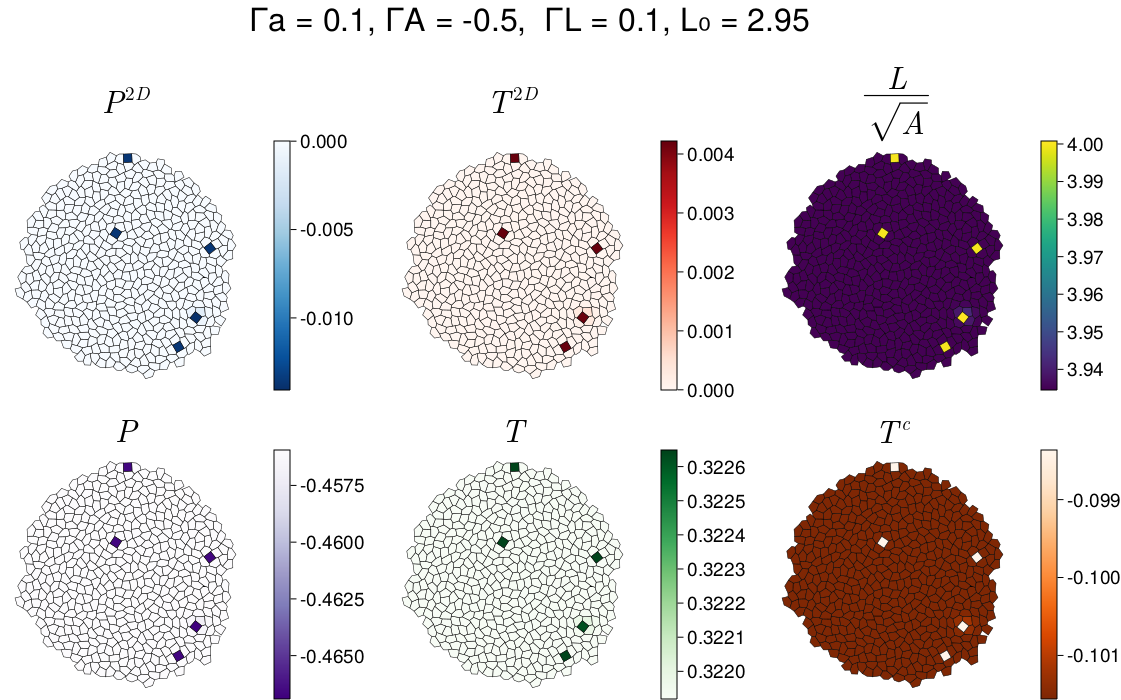

CairoMakie.Screen{IMAGE}


In [59]:
Ph=(cellAreas.*h .-1.0)
Th=Γa.*(2.0.*cellAreas .+ h.*cellPerimeters .- 1.0)
Thc=2*ΓL.*(cellPerimeters.-L₀)

shapeParam2D=cellPerimeters./(sqrt.(cellAreas))
slims=(minimum(abs.(shapeParam2D[1:nCells])), maximum(abs.(shapeParam2D[1:nCells])))
#slims=(minimum(abs.(shapeParam2D[1:nCells])), 4.1)


cellPolygons = makeCellPolygons(R,params,matrices)
@unpack cellAreas, cellPerimeters, cellPressures, cellTensions = matrices
Plims=(minimum(cellPressures[1:nCells]), maximum(cellPressures[1:nCells]))
Tlims=(minimum(cellTensions[1:nCells]), maximum(cellTensions[1:nCells]))

Phlims=(minimum(Ph), maximum(Ph))
Thlims=(minimum(Th), maximum(Th))
Thclims=(minimum(Thc), maximum(Thc))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a11=Axis(fig[1,1],aspect=DataAspect())
a21=Axis(fig[2,1],aspect=DataAspect())
a13=Axis(fig[1,3],aspect=DataAspect())
a23=Axis(fig[2,3],aspect=DataAspect())
a15=Axis(fig[1,5],aspect=DataAspect())
a25=Axis(fig[2,5],aspect=DataAspect())
hidedecorations!(a11)
hidespines!(a11)
hidedecorations!(a21)
hidespines!(a21)
hidedecorations!(a13)
hidespines!(a13)
hidedecorations!(a23)
hidespines!(a23)
hidedecorations!(a15)
hidespines!(a15)
hidedecorations!(a25)
hidespines!(a25)
for i=1:nCells
    poly!(a11,cellPolygons[i],color=cellPressures[i],colormap=cgrad(:Blues_9, rev=true),colorrange=Plims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a13,cellPolygons[i],color=cellTensions[i],colormap=cgrad(:Reds_9),colorrange=Tlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a15,cellPolygons[i],color=shapeParam2D[i],colormap=:viridis,colorrange=slims, strokecolor=(:black,1.0),strokewidth=0.5)

    poly!(a21,cellPolygons[i],color=Ph[i],colormap=cgrad(:Purples_9, rev=true),colorrange=Phlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a23,cellPolygons[i],color=Th[i],colormap=cgrad(:Greens_9),colorrange=Thlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a25,cellPolygons[i],color=Thc[i],colormap=cgrad(:Oranges_9, rev=true),colorrange=Thclims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))

colsize!(fig.layout,3,Aspect(1,1.0))
colsize!(fig.layout,5,Aspect(1,1.0))



Colorbar(fig[1,2],limits=colorrange=Plims,colormap=cgrad(:Blues_9, rev=true),flipaxis=true)
Colorbar(fig[1,4],limits=colorrange=Tlims,colormap=:Reds_9,flipaxis=true)
Colorbar(fig[1,6],limits=colorrange=slims,colormap=:viridis,flipaxis=true)


Colorbar(fig[2,2],limits=colorrange=Phlims,colormap=cgrad(:Purples_9, rev=true),flipaxis=true)
Colorbar(fig[2,4],limits=colorrange=Thlims,colormap=cgrad(:Greens_9),flipaxis=true)
Colorbar(fig[2,6],limits=colorrange=Thclims,colormap=cgrad(:Oranges_9, rev=true),flipaxis=true)

Label(fig[1,1,Top()],L"P^{2D}",fontsize = 32, rotation=0)
Label(fig[1,3,Top()],L"T^{2D}",fontsize = 32, rotation=0)
Label(fig[1,5,Top()],L"\frac{L}{\sqrt{A}}",fontsize = 32, rotation=0)


Label(fig[2,1,Top()],L"P",fontsize = 32, rotation=0)
Label(fig[2,3,Top()],L"T",fontsize = 32, rotation=0)
Label(fig[2,5,Top()],L"T^{c}",fontsize = 32, rotation=0)

#Label( fig[0,:],L"\Gamma_a = "*string(params.Γa)*L", \Gamma_A = "*string(params.ΓA)*L", \Gamma_L = "*string(params.ΓL)*L", L_0 = "*string(params.L₀),fontsize = 32, color = (:black, 1))

Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*",  ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"eigenmodes","Stress.png"),fig)
#save(datadir(f,"plots","PT_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

display(fig)

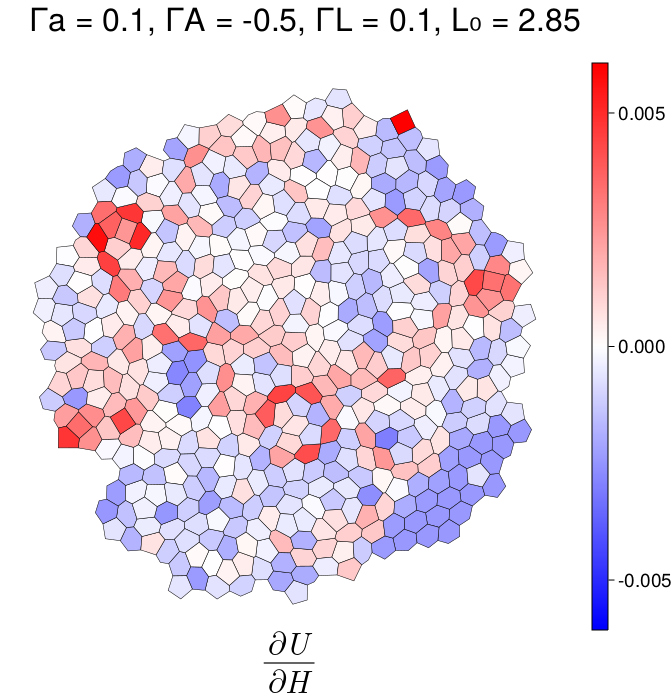

In [102]:
#Peff3D=Ph .+ (2/3).*Th.*(2.0.*cellAreas.+h.*cellPerimeters)./cellVolumes .+ (1/3).*ΓA.*(h.*cellPerimeters)./cellVolumes .+ Thc.*cellPerimeters./cellVolumes

cellPolygons = makeCellPolygons(R,params,matrices)
Fzlims=(-maximum(abs.(Fz)), maximum(abs.(Fz)))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())

hidedecorations!(a1)
hidespines!(a1)

for i=1:nCells
    poly!(a1,cellPolygons[i],color=Fz[i],colormap=:bwr,colorrange=Fzlims, strokecolor=(:black,1.0),strokewidth=0.5)

end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Fzlims,colormap=:bwr,flipaxis=true)

Label(fig[1,1,Bottom()],string(L"\frac{\partial U}{\partial H}"),fontsize = 32, rotation=0)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"plots","dUdH_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

fig

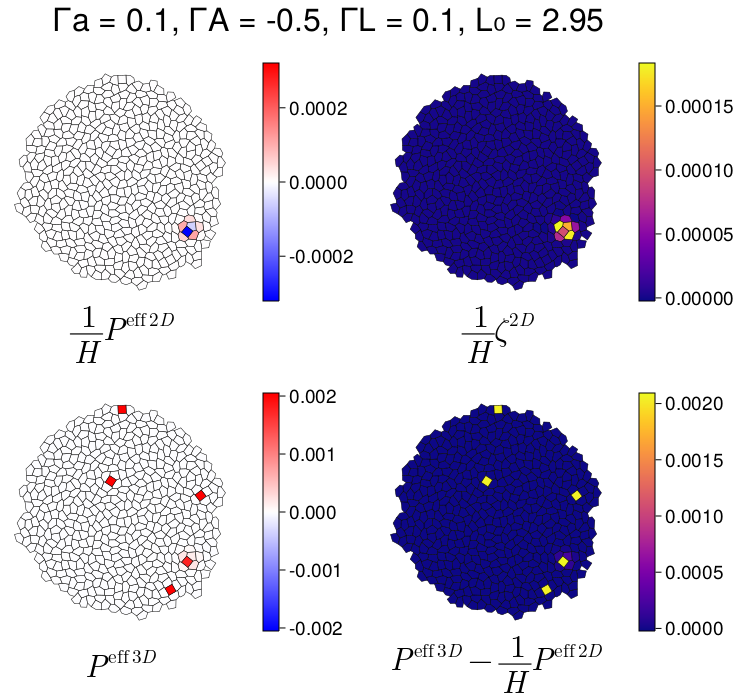

CairoMakie.Screen{IMAGE}


In [62]:


cellPolygons = makeCellPolygons(R,params,matrices)
@unpack cellAreas, cellPerimeters, cellPressures, cellTensions = matrices
Pe2Dlims=(-maximum(abs.(Peff2D./h)), maximum(abs.(Peff2D./h)))
Pe3Dlims=(-maximum(abs.(Peff3D)), maximum(abs.(Peff3D)))
delPefflims=(minimum(Peff3D.-(Peff2D./h)), maximum(Peff3D.-(Peff2D./h)))
zeta2Dlims=(minimum(ss2D./h), maximum(ss2D./h))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a11=Axis(fig[1,1],aspect=DataAspect())
a21=Axis(fig[2,1],aspect=DataAspect())
a13=Axis(fig[1,3],aspect=DataAspect())
a23=Axis(fig[2,3],aspect=DataAspect())
hidedecorations!(a11)
hidespines!(a11)
hidedecorations!(a21)
hidespines!(a21)
hidedecorations!(a13)
hidespines!(a13)
hidedecorations!(a23)
hidespines!(a23)
for i=1:nCells
    poly!(a11,cellPolygons[i],color=(Peff2D./h)[i],colormap=:bwr,colorrange=Pe2Dlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a21,cellPolygons[i],color=Peff3D[i],colormap=:bwr,colorrange=Pe3Dlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a13,cellPolygons[i],color=(ss2D./h)[i],colormap=:plasma,colorrange=zeta2Dlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a23,cellPolygons[i],color=(Peff3D.-(Peff2D./h))[i],colormap=:plasma,colorrange=delPefflims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))

colsize!(fig.layout,3,Aspect(1,1.0))

Colorbar(fig[1,2],limits=Pe2Dlims,colormap=:bwr,flipaxis=true)
Colorbar(fig[2,2],limits=Pe3Dlims,colormap=:bwr,flipaxis=true)
Colorbar(fig[1,4],limits=zeta2Dlims,colormap=:plasma,flipaxis=true)
Colorbar(fig[2,4],limits=delPefflims,colormap=:plasma,flipaxis=true)

Label(fig[1,1,Bottom()],L"\frac{1}{H}P^{\mathrm{eff}\,2D}",fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],L"P^{\mathrm{eff}\,3D}",fontsize = 32, rotation=0)

Label(fig[1,3,Bottom()],L"\frac{1}{H}\zeta^{2D}",fontsize = 32, rotation=0)
Label(fig[2,3,Bottom()],L"P^{\mathrm{eff}\,3D}-\frac{1}{H} P^{\mathrm{eff}\,2D}",fontsize = 32, rotation=0)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"eigenmodes","Stress.png"),fig)
#save(datadir(f,"plots","stress_Peff_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".png"),fig)

display(fig)

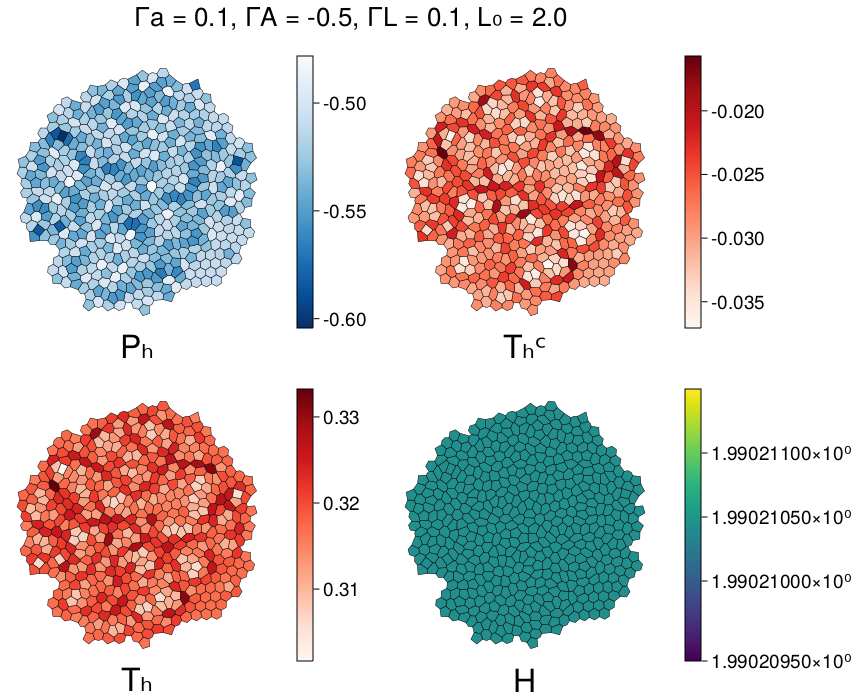

CairoMakie.Screen{IMAGE}


In [291]:
h=mean(cellHeights)
Ph=(cellAreas.*h .-1.0)
Th=Γa.*(2.0.*cellAreas .+ h.*cellPerimeters .- 1.0)
Thc=2*ΓL.*(cellPerimeters.-L₀)


cellPolygons = makeCellPolygons(R,params,matrices)
@unpack cellAreas, cellPerimeters, cellPressures, cellTensions = matrices
Plims=(minimum(Ph)-1e-6, maximum(Ph)+1e-6)
Tlims=(minimum(Th)-1e-6, maximum(Th)+1e-6)
Thclims=(minimum(Thc)-1e-6, maximum(Thc)+1e-6)
Hlims=(minimum(cellHeights[1:nCells])-1e-6, maximum(cellHeights[1:nCells])+1e-6)
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a11=Axis(fig[1,1],aspect=DataAspect())
a21=Axis(fig[2,1],aspect=DataAspect())
a13=Axis(fig[1,3],aspect=DataAspect())
a23=Axis(fig[2,3],aspect=DataAspect())
hidedecorations!(a11)
hidespines!(a11)
hidedecorations!(a21)
hidespines!(a21)
hidedecorations!(a13)
hidespines!(a13)
hidedecorations!(a23)
hidespines!(a23)
for i=1:nCells
    poly!(a11,cellPolygons[i],color=Ph[i],colormap=cgrad(:Blues_9, rev=true),colorrange=Plims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a21,cellPolygons[i],color=Th[i],colormap=cgrad(:Reds_9),colorrange=Tlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a13,cellPolygons[i],color=Thc[i],colormap=cgrad(:Reds_9),colorrange=Thclims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a23,cellPolygons[i],color=cellHeights[i],colormap=:viridis,colorrange=Hlims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))

colsize!(fig.layout,3,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Plims,colormap=cgrad(:Blues_9, rev=true),flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=Tlims,colormap=cgrad(:Reds_9),flipaxis=true)
Colorbar(fig[1,4],limits=colorrange=Thclims,colormap=cgrad(:Reds_9),flipaxis=true)
Colorbar(fig[2,4],limits=colorrange=Hlims,colormap=:viridis,flipaxis=true)

Label(fig[1,1,Bottom()],"Pₕ",fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],"Tₕ",fontsize = 32, rotation=0)

Label(fig[1,3,Bottom()],"Tₕᶜ",fontsize = 32, rotation=0)
Label(fig[2,3,Bottom()],"H",fontsize = 32, rotation=0)
Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 26, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"eigenmodes","Stress.png"),fig)
#save(datadir(f,"plots","pressure_tension_Γa_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*"_b_r.png"),fig)

display(fig)

In [ ]:
cellVolumes=cellAreas.*cellHeights
cellSurface=2.0.*cellAreas+cellPerimeters.*cellHeights
cellPolygons = makeCellPolygons(R,params,matrices)
Vlims=(minimum(abs.(cellVolumes[1:nCells])), maximum(abs.(cellVolumes[1:nCells])))
alims=(minimum(abs.(cellSurface[1:nCells])), maximum(abs.(cellSurface[1:nCells])))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=cellVolumes[i],colormap=:viridis,colorrange=Vlims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a2,cellPolygons[i],color=cellSurface[i],colormap=:viridis,colorrange=alims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Vlims,colormap=:viridis,flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=alims,colormap=:viridis,flipaxis=true)


Label(fig[1,1,Bottom()],string(L"Volume"),fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],string(L"Surface Area"),fontsize = 32, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"plots","vol_sa.png"),fig)
fig

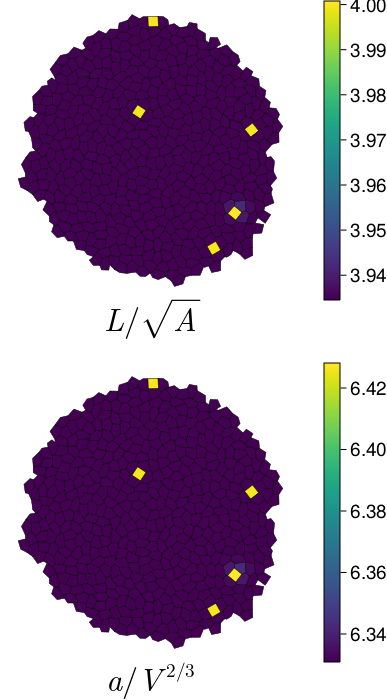

In [431]:
cellVolumes=cellAreas.*cellHeights
cellSurface=2.0.*cellAreas+cellPerimeters.*cellHeights
shapeParam2D=cellPerimeters./(sqrt.(cellAreas))
shapeParam3D=cellSurface./(cellVolumes.^(2/3))
cellPolygons = makeCellPolygons(R,params,matrices)
alims=(minimum(abs.(shapeParam2D[1:nCells])), maximum(abs.(shapeParam2D[1:nCells])))
blims=(minimum(abs.(shapeParam3D[1:nCells])), maximum(abs.(shapeParam3D[1:nCells])))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=shapeParam2D[i],colormap=:viridis,colorrange=alims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a2,cellPolygons[i],color=shapeParam3D[i],colormap=:viridis,colorrange=blims, strokecolor=(:black,1.0),strokewidth=0.5)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=alims,colormap=:viridis,flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=blims,colormap=:viridis,flipaxis=true)


Label(fig[1,1,Bottom()],string(L"L/\sqrt{A}"),fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],string(L"a/V^{2/3}"),fontsize = 32, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"plots","shapeparam.png"),fig)
fig

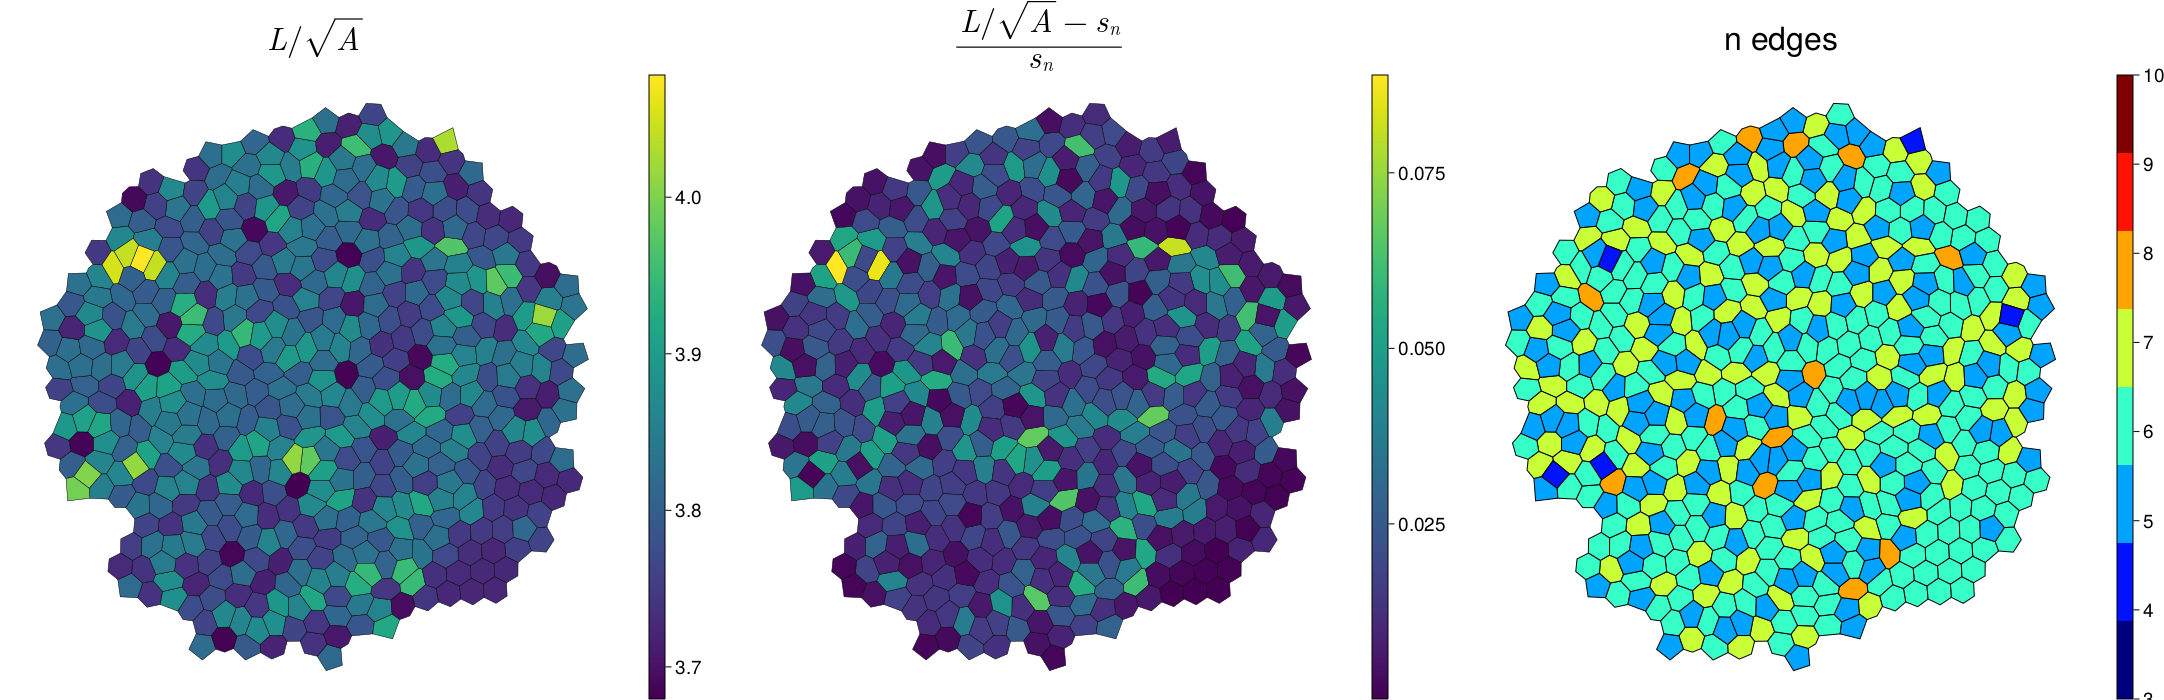

In [293]:

shapeParam2D=cellPerimeters./(sqrt.(cellAreas))

cellPolygons = makeCellPolygons(R,params,matrices)
alims=(minimum(abs.(shapeParam2D[1:nCells]))-1e-6, maximum(abs.(shapeParam2D[1:nCells]))+1e-6)
blims=(minimum(abs.(spdiff[1:nCells]))-1e-6, maximum(abs.(spdiff[1:nCells]))+1e-6)
clims=(minimum(abs.(spdiff_norm[1:nCells]))-1e-6, maximum(abs.(spdiff_norm[1:nCells]))+1e-6)

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[1,3],aspect=DataAspect())
a3=Axis(fig[1,5],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
hidedecorations!(a3)
hidespines!(a3)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=shapeParam2D[i],colormap=:viridis,colorrange=alims, strokecolor=(:black,1.0),strokewidth=0.5)
    #poly!(a2,cellPolygons[i],color=spdiff[i],colormap=:viridis,colorrange=blims, strokecolor=(:black,1.0),strokewidth=0.5)
    poly!(a2,cellPolygons[i],color=spdiff_norm[i],colormap=:viridis,colorrange=clims, strokecolor=(:black,1.0),strokewidth=0.5)

    poly!(a3,cellPolygons[i], color=cellEdgeCount[i], colorrange=(3, 10),colormap=cgrad(ColorSchemes.jet, 8, categorical=true),strokecolor=:black, strokewidth=1)

end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))
colsize!(fig.layout,3,Aspect(1,1.0))
colsize!(fig.layout,5,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=alims,colormap=:viridis,flipaxis=true)
#Colorbar(fig[1,4],limits=colorrange=blims,colormap=:viridis,flipaxis=true)
Colorbar(fig[1,4],limits=colorrange=clims,colormap=:viridis,flipaxis=true)

Colorbar(fig[1,6],limits=(3,10),colormap=cgrad(ColorSchemes.jet, 8, categorical=true),flipaxis=true)


Label(fig[1,1,Top()],string(L"L/\sqrt{A}"),fontsize = 32, rotation=0)
#Label(fig[1,3,Top()],string(L"L/\sqrt{A}-s_n"),fontsize = 32, rotation=0)
Label(fig[1,3,Top()],string(L"\frac{L/\sqrt{A}-s_n}{s_n}"),fontsize = 32, rotation=0)

Label(fig[1,5,Top()],string("n edges"),fontsize = 32, rotation=0)

#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"plots","shapeparam_norm.png"),fig)
fig

In [ ]:
#Height variatiob
evals, evecs=eigen(Matrix(B*Diagonal(ones(nEdges)-edgesP)*B'))
L=svd(Matrix(B*Diagonal(ones(nEdges)-edgesP)*B'))
Lp=L.V*Diagonal(vcat([1/s for s in L.S[1:end-1]],0))*L.U'
Lp2=pinv(Matrix(B*Diagonal(ones(nEdges)-edgesP)*B'))

H1=-Lp*Fz

H12=-Lp2*Fz

#Sigp=Diagonal(vcat([1/s for s in L.S[1:end-1]],0))

500×500 Diagonal{Float64, Vector{Float64}}:
 0.0948463   ⋅         ⋅         ⋅        …    ⋅        ⋅        ⋅       ⋅ 
  ⋅         0.100786   ⋅         ⋅             ⋅        ⋅        ⋅       ⋅ 
  ⋅          ⋅        0.101441   ⋅             ⋅        ⋅        ⋅       ⋅ 
  ⋅          ⋅         ⋅        0.102189       ⋅        ⋅        ⋅       ⋅ 
  ⋅          ⋅         ⋅         ⋅             ⋅        ⋅        ⋅       ⋅ 
  ⋅          ⋅         ⋅         ⋅        …    ⋅        ⋅        ⋅       ⋅ 
  ⋅          ⋅         ⋅         ⋅             ⋅        ⋅        ⋅       ⋅ 
  ⋅          ⋅         ⋅         ⋅             ⋅        ⋅        ⋅       ⋅ 
  ⋅          ⋅         ⋅         ⋅             ⋅        ⋅        ⋅       ⋅ 
  ⋅          ⋅         ⋅         ⋅             ⋅        ⋅        ⋅       ⋅ 
 ⋮                                        ⋱                             
  ⋅          ⋅         ⋅         ⋅             ⋅        ⋅        ⋅       ⋅ 
  ⋅          ⋅         ⋅         ⋅             

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\v35431nc\.julia\packages\Makie\6KcTF\src\scenes.jl:238


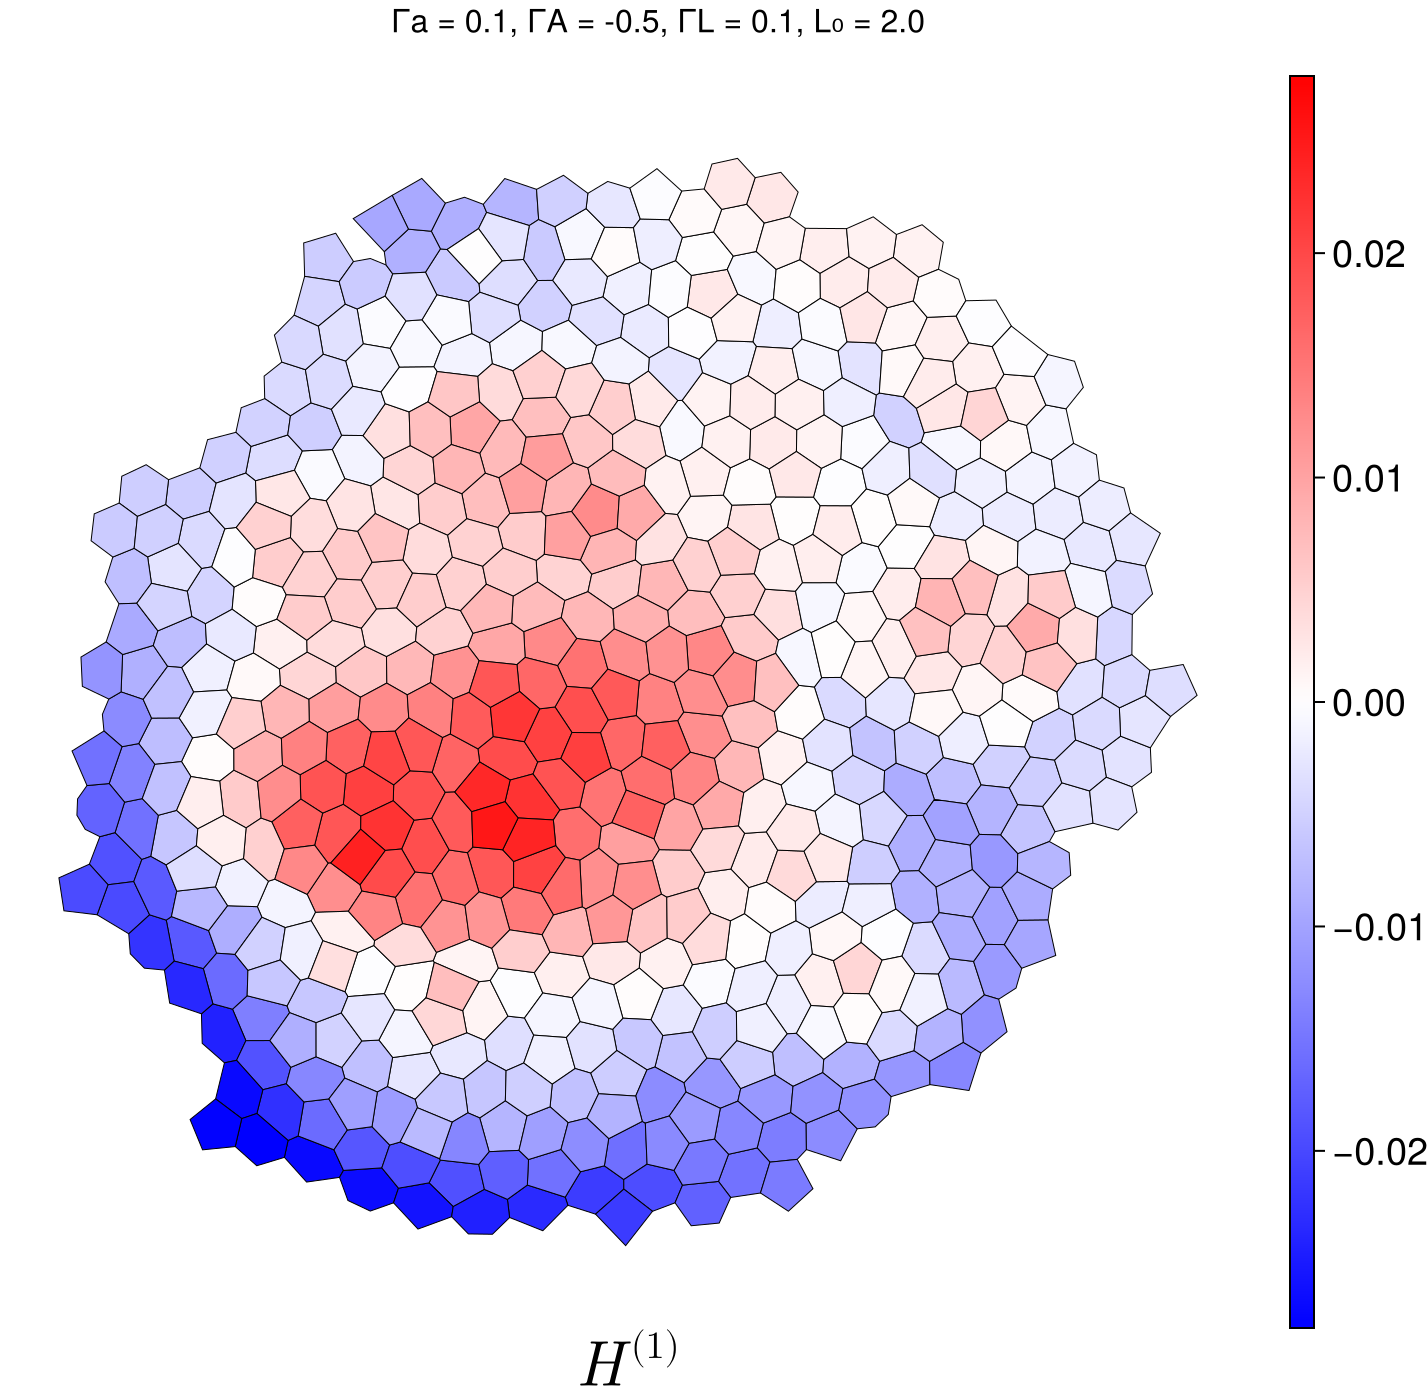

In [ ]:

cellPolygons = makeCellPolygons(R,params,matrices)
H1lims=(-maximum(abs.(H1)), maximum(abs.(H1)))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(2100,700))

a1=Axis(fig[1,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)



for i=1:nCells
    poly!(a1,cellPolygons[i],color=H1[i],colormap=:bwr,colorrange=H1lims, strokecolor=(:black,1.0),strokewidth=0.5)


end


colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=H1lims,colormap=:bwr,flipaxis=true)


Label(fig[1,1,Bottom()],string(L"H^{(1)}"),fontsize = 32, rotation=0)


Label( fig[0,:],"Γa = "*string(params.Γa)*", ΓA = "*string(params.ΓA)*", ΓL = "*string(params.ΓL)*", L₀ = "*string(params.L₀),fontsize = 16, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"plots","H1_"*string(params.Γa)*"_ΓA_"*string(params.ΓA)*"_ΓL_"*string(params.ΓL)*"_L0_"*string(params.L₀)*".eps"),fig)

fig